# Conservation of energy

In [63]:
dtl        = [0.01, 0.005, 0.0025, 0.00125];
iterationl = [500, 1000, 2000, 4000];

En = [[] for i in range(0, len(dtl))];

In [64]:
import matplotlib.pyplot as plt;
import numpy as np;
import numpy.linalg as linalg;
import math;

from sympy import *;
from sympy.utilities import *;
from ipywidgets import *;

def dostuf(index):
    # Symbol for symbolic expression
    x = Symbol('x');

    # Lagrange polynomial
    def lagrange(p, i):
        width = 1.0/p;
        this = i * width;
        # Numerator
        num = 1;
        for j in range(0, p + 1):
            if(j != i):
                num = Mul(num, x - (j*width));
        # Denominator
        denom = 1;
        for j in range(0, p + 1):
            if(j != i):
                denom = Mul(denom, this - (j*width));
        denom = Pow(denom, -1);
        return Mul(num, denom);

    degree = 1;
    phi = [];
    for i in range(0, degree + 1):
        phi += [lagrange(degree, i)];

    # Constant
    c = 1;

    # Delta time
    dt = dtl[index];

    # Amount of iterations
    iterations = iterationl[index];

    # Stepsize
    stepSize = 1000;

    # Time
    t = 0;

    # Elements
    elements = [];#[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0];
    
    for i in range(0, 10):
        elements += [i*0.1];
    
    
    elementCount = len(elements) - 1;

    # Extremal nodes
    minNode = min(elements);
    maxNode = max(elements);

    # Generate nodes
    nodeCount = 1 + (degree * elementCount);

    nodes = [];
    for i in range(0, elementCount):
        elementWidth = elements[i + 1] - elements[i];
        partWidth = elementWidth/degree;
        for p in range(0, degree):
            nodes += [elements[i] + (partWidth * p)];
    nodes += [maxNode];

    # Time coefficient matrix
    T = np.zeros((nodeCount, nodeCount));

    def integ(phi1, phi2, h):
        product = Mul(phi1, phi2);
        return h*integrate(product, (x, 0, 1));

    for i in range(0, elementCount):
        elementWidth = elements[i + 1] - elements[i];
        for n in range(0, degree + 1):
            for m in range(0, degree + 1):
                T[(degree * i) + n, (degree * i) + m] += integ(phi[n], phi[m], elementWidth);

    Tc = T.copy();

    for i in range(0,nodeCount):
        T[0,i]           = 0;
        T[nodeCount-1,i] = 0;
    T[0,0] = 1;
    T[nodeCount-1,nodeCount-1] = 1;

    #Time coefficient matrix

    S = np.zeros((nodeCount, nodeCount));

    def diffInteg(phi1, phi2, h, trans, invtrans):
        # Transform local to global
        gPhi1 = phi1.subs(x, invtrans);
        gPhi2 = phi2.subs(x, invtrans);
        # Take global derivative
        derGPhi1 = (diff(gPhi1, x));
        derGPhi2 = (diff(gPhi2, x));
        # Transform global to local
        derPhi1 = derGPhi1.subs(x, trans);
        derPhi2 = derGPhi2.subs(x, trans);
        product = Mul(derPhi1, derPhi2);
        return h*integrate(product, (x,0,1));

    for i in range(0, elementCount):
        elementWidth = elements[i + 1] - elements[i];
        transform = (elementWidth * x) + (elements[i]);
        inversetransform = (x - elements[i])/elementWidth;
        for n in range(0, degree + 1):
            for m in range(0, degree + 1):
                S[(degree * i) + n, (degree * i) + m] += diffInteg(phi[n], phi[m], elementWidth, transform, inversetransform);

    Sc = S.copy();
    for i in range(0,nodeCount):
        S[0,i]           = 0;
        S[nodeCount-1,i] = 0;

        # A single time step
    def iteration(v, vDer):
        vNew = v + dt*vDer;
        q = -c*c*S@v;
        r = linalg.solve(T, q);
        vDerNew = vDer + dt*r;
        return (vNew, vDerNew);

    # Evaluation
    def ev(u, pos):
        # Find element the pos(ition) is in
        for i in range(0, elementCount):
            if(elements[i] <= pos <= elements[i+1]):
                elementWidth = elements[i + 1] - elements[i];
                transformedPos = (pos - elements[i])/elementWidth;
                # Calculate linear sum
                sum = 0;
                for p in range(0, degree+1):
                    sum += u[(i*degree) + p]*phi[p].subs(x, transformedPos);
                return sum;
        return 0;

    gaussA = 1;
    gaussB = 0.25;
    gaussC = 0.05;
    # The real solution
    def realU(x, t):
        modx = x % 0.5;
        return gaussA*math.exp( -( (modx-gaussB)*(modx-gaussB) )/(gaussC*gaussC) );


    def energy(u, uDer):
        su = 0;
        for i in range(0, nodeCount):
            for j in range(0, nodeCount):
                su += Tc[i][j] * uDer[i] * uDer[j];
                su += Sc[i][j] * c * c * u[i] * u[j];
        return su;

    # Set initial value
    u    = np.zeros((nodeCount, 1));
    uDer = np.zeros((nodeCount, 1));

    k = 2*math.pi;

    for i in range(0, nodeCount):
        coord   = nodes[i];
        u[i]    = realU(coord, 0);
        uDer[i] = 0;

    data = [];
    data.append(u);
    En[index].append(energy(u, uDer));

    bigspacing = np.linspace(0.0, 2.0, 100);

    uNew    = np.zeros((nodeCount, 1));
    uDerNew = np.zeros((nodeCount, 1));

    for i in range(0, iterations):
        uNew, uDerNew = iteration(u,uDer);
        u = uNew;
        uDer = uDerNew;
        data.append(u);
        En[index].append(energy(u, uDer));
        t += dt;
    
    '''
    if(i != 0):
        return;
    spacing = np.linspace(0.0, 1.0, 100);
    evaluation = np.linspace(0.0, 1.0, 100);
    for i in range(0, 100):
        evaluation[i] = ev(data[0], evaluation[i]);
    plt.plot(spacing, evaluation, "b-");
    plt.ylabel("U(x, 0)");
    plt.xlabel("x");
    '''
    #plt.plot(data[i]);
    
for i in range(0, len(dtl)):
    dostuf(i);
    

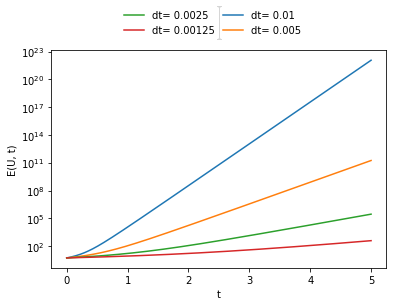

In [66]:
plt.yscale('log')
plt.plot(np.linspace(0.0, 5.0, 500), En[0][:500], label="dt= " + str(dtl[0]));
plt.plot(np.linspace(0.0, 5.0, 1000), En[1][:1000], label="dt= " + str(dtl[1]));
plt.plot(np.linspace(0.0, 5.0, 2000), En[2][:2000], label="dt= " + str(dtl[2]));
plt.plot(np.linspace(0.0, 5.0, 4000), En[3][:4000], label="dt= " + str(dtl[3]));
plt.legend(bbox_to_anchor=(0.5, 1.05, 0., 0.1), loc=3,
       ncol=2, mode="expand", borderaxespad=0.);
plt.ylabel("E(U, t)");
plt.xlabel("t");

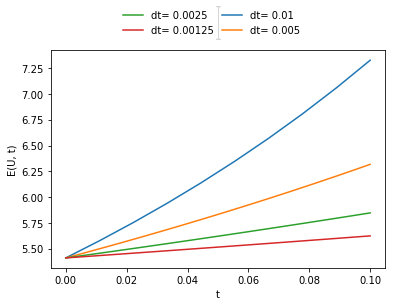

In [67]:
plt.yscale('linear')
plt.plot(np.linspace(0.0, 0.1, 10), En[0][:10], label="dt= " + str(dtl[0]));
plt.plot(np.linspace(0.0, 0.1, 20), En[1][:20], label="dt= " + str(dtl[1]));
plt.plot(np.linspace(0.0, 0.1, 40), En[2][:40], label="dt= " + str(dtl[2]));
plt.plot(np.linspace(0.0, 0.1, 80), En[3][:80], label="dt= " + str(dtl[3]));
plt.legend(bbox_to_anchor=(0.5, 1.05, 0., 0.1), loc=3,
       ncol=2, mode="expand", borderaxespad=0.);
plt.ylabel("E(U, t)");
plt.xlabel("t");